# CNN Model for Toxic Language Classification

## Set up

##### Load packages

In [2]:
%%capture

import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import nltk
nltk.download("all")
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

%matplotlib inline

##### Set Parameters

In [3]:
BATCH_SIZE = 16
MAX_SENT_LENGTH = 200
EMBED_DIM = 300
NUM_CLASSES = 6

##### Load data

In [31]:
def balance_data(dataset, label):
    '''
    Depending on the chosen label, the function provide 
    a balanced dataset on the label. The result dataset 
    will have equal number of label == 1/0
    '''
    pos_data = dataset[dataset[label] == 1]
    neg_data = dataset[dataset[label] == 0]
    neg_data_sample = neg_data.sample(n=len(pos_data), random_state=12)

    df = pd.concat([neg_data_sample, pos_data])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

##### GPU set up

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


##### Pre-trained text embedding set up 

**GloVe**

In [6]:
from itertools import combinations
from torchtext.vocab import GloVe

VECTOR_CACHE_DIR = './glove/.vector_cache'

glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

# print(glove.get_vecs_by_tokens(["this", "is", "a", "comment"]))
# print(glove.get_vecs_by_tokens(["this", "is", "a", "comment"]).shape)

## Data Preparation


##### Tokenize word and map with embeddings

In [7]:
from nltk.tokenize import word_tokenize

def process_input(batch):
    '''
    Tokenize a batch of texts:
        - convert sentence to lower case
        - tokenize word with package `word_tokenize`
        - add paddings to MAX_SENT_LENGTH
        - convert tokenized sentence into GloVe embeddings
        - return a numpy array of input vectors 
    '''

    # set up containers
    y = torch.zeros(BATCH_SIZE)
    x = torch.zeros(BATCH_SIZE, MAX_SENT_LENGTH, EMBED_DIM)
    
    for i, (sent, label) in enumerate(batch):

        sent = sent.lower()
        tokenized_sent = word_tokenize(sent)

        # perform padding or truncate
        if len(tokenized_sent) < MAX_SENT_LENGTH:
            tokenized_sent += ['<pad>'] * (MAX_SENT_LENGTH - len(tokenized_sent))
        else:
            tokenized_sent = tokenized_sent[:MAX_SENT_LENGTH]

        vecs = glove.get_vecs_by_tokens(tokenized_sent)

        x[i] = vecs
        y[i] = label
    
    y = y.type(torch.LongTensor)

    return x, y 


##### Custome Dataset

In [8]:
# customized dataset: 

class CustomDataset(Dataset):
    '''
    '''
    def __init__(self, df):
        # self.is_test = is_test
        self.dataframe = df
        self.label_name = df.columns[-1]
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['comment_text']
        label = self.dataframe.iloc[idx][self.label_name]
        return text, label


##### Create Data Loader

In [38]:
def create_loaders(data):
    '''
    take one dataframe and create 3 loaders
    '''
    # split data: train 70%, validation 20%, test 10%

    train_df, rest_df = train_test_split(data, test_size=0.3, random_state=1)
    val_df, test_df = train_test_split(rest_df, test_size=0.33, random_state=1)

    # convert dataframes into cusmotized datasets

    train_data = CustomDataset(train_df)
    val_data = CustomDataset(val_df)
    test_data = CustomDataset(test_df)

    # create dataloader
    # droplast: if last batch is incomplete, we drop the last batch

    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                                collate_fn=process_input, drop_last=True)

    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, 
                                collate_fn=process_input, drop_last=True)

    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, 
                                collate_fn=process_input, drop_last=True)
    
    return train_dataloader, val_dataloader, test_dataloader

In [23]:
# for i, (text, label) in enumerate(test_dataloader):
#     print(i)
#     print(text)
#     print(label)

#     if i == 2:
#         break

## Modeling


##### CNN Version 0 </p>

For the first model, we are testing the following parameters

|Description         |Values           |
|:------------------:|:---------------:|
|input word vectors  |GloVe            |
|embedding size      |300              |
|filter sizes        |(2, 3, 4, 5)     |
|num filters         |(64, 64, 64, 64) |
|activation          |ReLU             |
|pooling             |1-max pooling    |
|dropout rate        |0.5              |

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_NLP(nn.Module):
    '''
    An 1D Convulational Neural Network for Sentence Classification.
    '''

    def __init__(self, filter_sizes=[2, 3, 4, 5], num_filters=[64, 64, 64, 64], 
                 embed_dim=EMBED_DIM, num_classes=2, dropout=0.5):
        """

        Args:
            pretrained_embedding (torch.Tensor): size (max_sent_length, embed_dim)
            freeze_embedding (bool): set to False by default
            max_sent_length (int): longest sentence allowed
            embed_dim (int): dimension of word vectors, by default: 300
            filter_sizes (List[int]): list of filter sizes, by default: [2, 3, 4, 5]
            num_filters (List[int]): list of number of filters, [64] * 4
            n_classes (int): number of classes, by default: 2
            dropout (float): Dropout rate, by default: 0.5
        """

        super(CNN_NLP, self).__init__()

        # # Embedding layer
        # if pretrained_embedding is not None:
        #     self.vocab_size, self.embed_dim = pretrained_embedding.shape
        #     self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
        #                                                   freeze=freeze_embedding)
        # else:
        #     self.embed_dim = embed_dim
        #     self.embedding = nn.Embedding(num_embeddings=vocab_size,
        #                                   embedding_dim=self.embed_dim,
        #                                   padding_idx=0,
        #                                   max_norm=5.0)

        self.embed_dim = embed_dim
        
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim, 
                      out_channels=num_filters[i], 
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))])
        
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input):
        """Perform a forward pass through the network.

        Args:
            input (torch.Tensor): tensor of batch of sentences with shape
            (batch_size, max_sent_length, embedding_dim)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
            n_classes)
        """

        # permute input to match the shape requirement of `nn.Conv1d`.
        # x_reshaped shape: (BATCH_SIZE, EMBED_DIM, MAX_SENT_LENGTH)
        x_reshaped = input.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

## Training

In [11]:
import torch.optim as optim

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")

def initilize_model(embed_dim=EMBED_DIM, filter_sizes=[2, 3, 4, 5], num_filters=[64, 64, 64, 64], 
                    num_classes=2, dropout=0.5, learning_rate=0.01):

    '''
    Instantiate a CNN model and an optimizer.
    '''

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    cnn_model = CNN_NLP(filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        embed_dim=embed_dim,
                        num_classes=num_classes,
                        dropout=dropout)
    
    cnn_model.to(device)

    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

In [12]:
import random
import time

loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    '''
    Set seed for reproducibility.
    '''

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


def evaluate_val(model, val_dataloader):
    '''
    After the completion of each training epoch, 
    measure the model's performance on our validation set.
    '''

    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:

        b_input, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


def train(model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=False):
    '''
    Train the CNN model.
    Inputs: 
        model: initialized CNN model 
        optimizer: initialized optimizer 
        train_dataloader: DataLoader object 
        val_dataloader: DataLoader object
        epochs: number of epochs for training, set to 10 by defaut
        check_train_loss: return list of training loss for each
                          epoch, set to False by default
    return:
        best_model: CNN_NLP object with highest validation accuracy
        val_accuracies: list of validation accuracies for each epoch
        val_losses: list of validation loss for each epoch
        train_losses (if check_train_loss): list of training loss for each epoch
    '''
    
    best_model = None
    val_accuracies = []
    train_losses = []
    val_losses = []
    best_accuracy = 0

    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):

        t0_epoch = time.time()
        total_loss = 0
        model.train()

        # ============= Training =============

        for step, batch in enumerate(train_dataloader):

            # forward and compute loss
            b_input, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        time_elapsed = time.time() - t0_epoch

        # ============= Evaluation =============

        val_loss, val_accuracy = evaluate_val(model, val_dataloader)

        if not best_model:
            best_model = model

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model

        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        time_elapsed = time.time() - t0_epoch
        print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

    if check_train_loss:
        return best_model, val_accuracies, val_losses, train_losses
    
    return best_model, val_accuracies, val_losses

## Testing

In [13]:
from sklearn.metrics import confusion_matrix

def test_model(model, test_dataloader):
    '''
    test the model on test data, return the test loss 
    and the confusion matrix
    '''

    model.eval()

    predictions = []
    labels = []
    losses = []
    
    for i, batch in enumerate(test_dataloader):

        b_input, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)

        loss = loss_fn(logits, b_labels)
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()

        # ids.extend(list(b_ids))
        labels.extend(list(b_labels))
        predictions.extend(list(preds))

    test_loss = np.mean(losses)
    cm = confusion_matrix(labels, predictions)

    return test_loss, cm

def eval_cm(cm):
    '''
    Ravel a comfusion matrix, and return 
    accuracy, precision, recall, f1 

    Input:
        model: best performed CNN_NLP model 
        test_dataloader: DataLoader for testing data

    Return:
        DataFrame format of four measurements
    '''

    tn, fp, fn, tp = cm.ravel() 
    accu = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (prec * recall) / (prec + recall)

    eval = {"Accuracy": [accu],
            "Precision": [prec],
            "Recall": [recall],
            "F1": [f1]}
    
    return pd.DataFrame(eval)


In [14]:
def get_predictions(model, test_dataloader):
    '''
    After the completion of each training epoch, measure the model's
    performance on our validation set.

    Input:
        model: best performed CNN_NLP model 
        test_dataloader: DataLoader for testing data

    Return:
        preds (list): predictions on testing data, 
        last batch might be dropped if not full
    '''

    model.eval()
    preds = []

    for batch in test_dataloader:
        b_input, _ = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input)
        b_pred = torch.argmax(logits, dim=1).flatten()
        for v in b_pred:
            preds.append(int(v))

    return preds


def get_tag(row):
    '''
    helper function to get 4 different tags based on 
    the predicted value and the actual value: 
    "TP", "TN", "FP", "FN" 

    the labels are binary, so we only have 4 conditions:
        label(1) * pred(1) = 1  ---> "TP"
        label(0) - pred(0) = 0  ---> "TN" (excluding previous condition)
        label(0) - pred(1) = -1 ---> "FP" (excluding previous conditions)
        label(1) - pred(0) = 1  ---> "FN" (excluding previous conditions)
    
    return: "TP", "TN", "FP", "FN" (4 tags)
            and 'N/A' (not suppose to happen)
    '''
    
    pred = row["pred"]
    label = row["label"]

    if label * pred == 1:
        return 'TP'
    elif label - pred == 0:
        return 'TN'
    elif label - pred == -1:
        return 'FP'
    elif label - pred == 1:
        return 'FN'
    else:
        return 'N/A'


def tag_performances(preds, df):
    '''
    take predictions from model on test_df, tag 
    cases of prediction: "TP", "TN", "FP", "FN" 
    
    Inputs:
        preds (list): a list of predicions from model
        df (DataFrame): test data in DataFrame form, 
                        the last column should be the true label
    Return: 
        df (DataFrame) include testing data and predictions
    '''

    N = len(preds)

    assert N == len(df) - (len(df) % 16), \
    "AssertionError: number of predictions should equal to the number of examples"

    # change the last column name
    last_column_name = df.columns[-1]
    df = df.rename(columns={last_column_name: "label"})

    # add new column for model predictions
    df = df[: N]
    df["pred"] = preds

    # tag "TP", "TN", "FP", "FN" for each pair
    df['tag'] = df.apply(get_tag, axis=1)

    return df

## Compare Different Models

#### REPORT 1 `model_0` for Identity Hate

In [16]:
# train model with 10 epocks
cnn_model, optimizer = initilize_model()
ih_model_0, val_accuracies_0, val_losses_0 = train(cnn_model, optimizer, train_dataloader, val_dataloader)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.199653   |  0.168554  |   95.66   |  214.62  
   2    |   0.170443   |  0.160630  |   95.70   |  209.30  
   3    |   0.159570   |  0.152211  |   95.73   |  209.48  
   4    |   0.150355   |  0.142832  |   95.76   |  209.85  
   5    |   0.140390   |  0.134124  |   95.76   |  208.67  
   6    |   0.132846   |  0.127707  |   95.83   |  209.22  
   7    |   0.125316   |  0.122823  |   95.82   |  214.46  
   8    |   0.120078   |  0.119390  |   95.87   |  210.12  
   9    |   0.116925   |  0.117131  |   95.83   |  212.69  
  10    |   0.115052   |  0.115022  |   95.92   |  225.74  


Training complete! Best accuracy: 95.92%.


In [25]:
# with open('ih_model_0.pkl', 'wb') as file:
#     pickle.dump(ih_model_0, file)

Text(0.5, 1.0, 'Validation accuracy of `best_model_0` for Identity Hate label (10 epochs)')

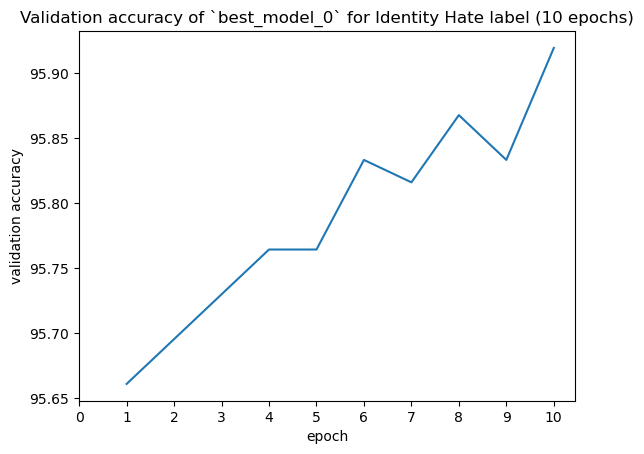

In [18]:
epochs = [x + 1 for x in range(10)]
plt.plot(epochs, val_accuracies_0)
plt.xticks(range(0, 11))
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy of `best_model_0` for Identity Hate label (10 epochs)')



**Report:** </p>

**Training performance:**

| Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
|:------:|:------------:|:----------:|:---------:|:-------:|


In [23]:
ih_test_loss, ih_cm = test_model(ih_model_0, test_dataloader)
eval_cm(ih_cm)

,Accuracy,Precision,Recall,F1
0,0.963687,0.576923,0.267857,0.365854


In [24]:
print("The test loss for identity hate", ih_test_loss)

The test loss for identity hate 0.10865403341868236


In [20]:
preds = get_predictions(ih_model_0, test_dataloader)
results_cnn_0 = tag_performances(preds, test_df)

In [21]:
# check some of the false negative predictions
false_neg_cnn_0 = results_cnn_0[results_cnn_0["tag"] == "FN"]
false_neg_cnn_0.to_csv("FN_model0.csv")
false_neg_cnn_0.head(5)

,id,comment_text,label,pred,tag
6032,0be7965b23078261,"""Just face the truth: you can't escape it!==\n...",1,0,FN
6892,81dfb0e007a1e25b,You son of a bitch \nI was the one who recogni...,1,0,FN
27007,33b9c2da3dafd4c1,Latin Americans have to be some of the most ig...,1,0,FN
6869,dcf06fa487ee6589,"All editor are gay. Therefore, the guys who b...",1,0,FN
6907,4f1d3f26583715c3,MUSLIM SCUM go die soon will you,1,0,FN


In [22]:
# check some of the false positive predictions
false_pos_cnn_0 = results_cnn_0[results_cnn_0["tag"] == "FP"]
false_pos_cnn_0.to_csv("FP_model0.csv")
false_pos_cnn_0.head(5)

,id,comment_text,label,pred,tag
9405,ae381ee72f42819f,Why did you stop my edit \n\nYou fukin gay prick,0,1,FP
27222,8fa66f9c673e280e,YOU BLOCKED ME FOR A WHOLE MONTH? YOU SAID ONL...,0,1,FP
2756,32930fcdeee72756,Hi ... \n\n...Joseph.\n\nare you gay?,0,1,FP
14673,2bca2246218edc8e,and decided to become gay,0,1,FP
14186,60e1a471c3b2ed65,queer ur gay i hope u read this,0,1,FP


In [109]:
# for i, row in false_neg_cnn_0.iterrows():
#     id = row["id"]
#     sent = row["comment_text"]
#     print("id:")
#     print(id)
#     print("comment: ")
#     print(sent)
#     print("============")

#### REPORT 2 `model_0` for Identity Hate (Balanced data)

In [37]:
# load balanced data
data = pd.read_csv("../data/train.csv")
data = data.reset_index()
# data = data[["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
data = data[["id", "comment_text", "identity_hate"]]
df = balance_data(data, "identity_hate")
print("for identity_hate label, balanced dataset has {} records.".format(len(df)))

for identity_hate label, balanced dataset has 2810 records.


In [43]:
train_dataloader, val_dataloader, test_dataloader = create_loaders(df)

In [44]:
IH_model, optimizer = initilize_model()
IH_model_best, IH_val_accuracies, IH_val_losses, IH_train_losses = \
    train(IH_model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=True)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.660931   |  0.608375  |   80.54   |   19.92  
   2    |   0.588046   |  0.545626  |   83.75   |   20.67  
   3    |   0.526944   |  0.493973  |   85.89   |   20.61  
   4    |   0.482096   |  0.450604  |   87.14   |   20.55  
   5    |   0.443451   |  0.415104  |   88.39   |   20.74  
   6    |   0.402012   |  0.385563  |   89.29   |   20.77  
   7    |   0.374667   |  0.361096  |   89.64   |   20.51  
   8    |   0.348549   |  0.340057  |   90.36   |   20.50  
   9    |   0.330521   |  0.322950  |   91.07   |   21.47  
  10    |   0.305883   |  0.308579  |   90.89   |   20.78  


Training complete! Best accuracy: 91.07%.


In [45]:
# pickle the model
with open('IH_model_best.pkl', 'wb') as file:
    pickle.dump(IH_model_best, file)

# load the pickled model
# with open('best_model_0_20e.pkl', 'rb') as file:
#     best_model_0_20e = pickle.load(file)

Text(0.5, 1.0, 'Validation accuracy of `IH_model_best` (10 epochs)')

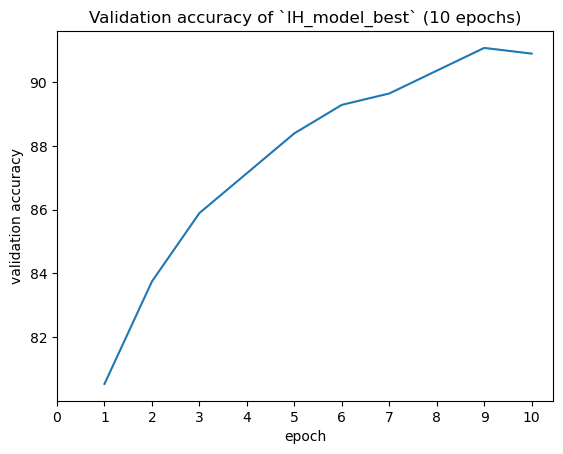

In [47]:
epochs = [x + 1 for x in range(10)]

plt.plot(epochs, IH_val_accuracies)
plt.xticks(range(0, 11))
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Validation accuracy of `IH_model_best` (10 epochs)')

In [48]:
IH_test_loss, IH_cm = test_model(IH_model_best, test_dataloader)

print("After 10 epochs of training, the IH_model_best has testing loss of {}"\
      .format(round(IH_test_loss, 3)))

After 10 epochs of training, the IH_model_best has testing loss of 0.323


In [49]:
eval_cm(IH_cm)

,Accuracy,Precision,Recall,F1
0,0.882353,0.902098,0.877551,0.889655


#### REPORT 3 `model_0` for Obscene (Balanced data)

In [53]:
# load balanced data
data = pd.read_csv("../data/train.csv")
data = data.reset_index()
# data = data[["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
data = data[["id", "comment_text", "obscene"]]
df = balance_data(data, "obscene")
train_dataloader, val_dataloader, test_dataloader = create_loaders(df)
print("for obscene label, balanced dataset has {} records.".format(len(df)))

for obscene label, balanced dataset has 16898 records.


In [54]:
OB_model, optimizer = initilize_model()
OB_model_best, OB_val_accuracies, OB_val_losses, OB_train_losses = \
    train(OB_model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=True)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.532201   |  0.387605  |   89.09   |  165.51  
   2    |   0.336360   |  0.275835  |   91.16   |  185.50  
   3    |   0.269867   |  0.236662  |   91.80   |  135.62  
   4    |   0.241976   |  0.219134  |   92.13   |  125.66  
   5    |   0.230950   |  0.209099  |   92.39   |  125.72  
   6    |   0.215347   |  0.202849  |   92.57   |  124.72  
   7    |   0.209070   |  0.196777  |   92.92   |  124.32  
   8    |   0.202713   |  0.192662  |   92.92   |  124.37  
   9    |   0.197259   |  0.189279  |   93.04   |  124.06  
  10    |   0.189524   |  0.185894  |   93.19   |  124.33  


Training complete! Best accuracy: 93.19%.


In [57]:
OB_test_loss, OB_cm = test_model(OB_model_best, test_dataloader)

print("After 10 epochs of training, the OB_model_best has testing loss of {}"\
      .format(round(OB_test_loss, 3)))

After 10 epochs of training, the OB_model_best has testing loss of 0.189


In [58]:
eval_cm(OB_cm)

,Accuracy,Precision,Recall,F1
0,0.930889,0.939163,0.917079,0.92799


In [59]:
# # pickle the model
# with open('OB_model_best.pkl', 'wb') as file:
#     pickle.dump(OB_model_best, file)

#### REPORT 4 `model_0` for Threat (Balanced data)

In [60]:
# load balanced data
data = pd.read_csv("../data/train.csv")
data = data.reset_index()
# data = data[["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
data = data[["id", "comment_text", "threat"]]
df = balance_data(data, "threat")
train_dataloader, val_dataloader, test_dataloader = create_loaders(df)
print("for threat label, balanced dataset has {} records.".format(len(df)))

for threat label, balanced dataset has 956 records.


In [61]:
TH_model, optimizer = initilize_model()
TH_model_best, TH_val_accuracies, TH_val_losses, TH_train_losses = \
    train(TH_model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=True)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.685880   |  0.645582  |   76.56   |   8.42   
   2    |   0.639902   |  0.615314  |   82.81   |   8.59   
   3    |   0.612405   |  0.588967  |   85.42   |   12.13  
   4    |   0.586320   |  0.564782  |   86.46   |   11.81  
   5    |   0.562873   |  0.542297  |   89.06   |   12.23  
   6    |   0.532023   |  0.521749  |   89.06   |   8.93   
   7    |   0.521742   |  0.501979  |   89.58   |   7.18   
   8    |   0.498166   |  0.484128  |   90.62   |   7.16   
   9    |   0.477987   |  0.467373  |   90.62   |   6.95   
  10    |   0.459434   |  0.451383  |   91.15   |   8.09   


Training complete! Best accuracy: 91.15%.


In [62]:
TH_test_loss, TH_cm = test_model(TH_model_best, test_dataloader)

print("After 10 epochs of training, the OB_model_best has testing loss of {}"\
      .format(round(TH_test_loss, 3)))

After 10 epochs of training, the OB_model_best has testing loss of 0.5


In [63]:
eval_cm(TH_cm)

,Accuracy,Precision,Recall,F1
0,0.875,0.871795,0.871795,0.871795


In [64]:
# pickle the model
with open('TH_model_best.pkl', 'wb') as file:
    pickle.dump(TH_model_best, file)

#### REPORT 5 `model_0` for Insult (Balanced data)

In [65]:
# load balanced data
data = pd.read_csv("../data/train.csv")
data = data.reset_index()
# data = data[["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
data = data[["id", "comment_text", "insult"]]
df = balance_data(data, "insult")
train_dataloader, val_dataloader, test_dataloader = create_loaders(df)
print("for insult label, balanced dataset has {} records.".format(len(df)))

for insult label, balanced dataset has 15754 records.


In [70]:
IN_model, optimizer = initilize_model()
IN_model_best, IN_val_accuracies, IN_val_losses, IN_train_losses = \
    train(IN_model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=True)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.544648   |  0.410889  |   86.96   |   66.51  
   2    |   0.373684   |  0.313018  |   89.02   |   63.14  
   3    |   0.307464   |  0.272831  |   89.75   |   63.37  
   4    |   0.277340   |  0.252839  |   90.36   |   61.80  
   5    |   0.258143   |  0.241002  |   90.70   |   61.86  
   6    |   0.242211   |  0.233397  |   91.12   |   59.40  
   7    |   0.235105   |  0.228194  |   91.53   |   60.27  
   8    |   0.228880   |  0.224138  |   91.72   |   61.41  
   9    |   0.219741   |  0.220212  |   92.04   |   61.01  
  10    |   0.215010   |  0.217129  |   92.10   |   60.81  


Training complete! Best accuracy: 92.10%.


In [71]:
IN_test_loss, IN_cm = test_model(IN_model_best, test_dataloader)

print("After 10 epochs of training, the OB_model_best has testing loss of {}"\
      .format(round(IN_test_loss, 3)))

After 10 epochs of training, the OB_model_best has testing loss of 0.192


In [72]:
eval_cm(IN_cm)

,Accuracy,Precision,Recall,F1
0,0.931701,0.932065,0.924528,0.928281


In [67]:
with open('IH_model_best.pkl', 'wb') as file:
    pickle.dump(IH_model_best, file)

#### REPORT 6 `model_0` for Severe_toxic (Balanced data)

In [73]:
# load balanced data
data = pd.read_csv("../data/train.csv")
data = data.reset_index()
# data = data[["id", "comment_text", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
data = data[["id", "comment_text", "severe_toxic"]]
df = balance_data(data, "severe_toxic")
train_dataloader, val_dataloader, test_dataloader = create_loaders(df)
print("for severe_toxic label, balanced dataset has {} records.".format(len(df)))

for severe_toxic label, balanced dataset has 3190 records.


In [75]:
ST_model, optimizer = initilize_model()
ST_model_best, ST_val_accuracies, ST_val_losses, ST_train_losses = \
    train(ST_model, optimizer, train_dataloader, val_dataloader, epochs=10, check_train_loss=True)

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.625131   |  0.542921  |   92.03   |   14.79  
   2    |   0.499484   |  0.435131  |   93.44   |   14.59  
   3    |   0.410166   |  0.360513  |   93.28   |   14.93  
   4    |   0.349754   |  0.308802  |   93.44   |   14.24  
   5    |   0.309253   |  0.273301  |   93.59   |   14.14  
   6    |   0.271856   |  0.248348  |   93.91   |   15.19  
   7    |   0.258141   |  0.231339  |   94.06   |   14.53  
   8    |   0.241656   |  0.218568  |   93.91   |   13.95  
   9    |   0.221666   |  0.209094  |   93.91   |   14.63  
  10    |   0.212213   |  0.201903  |   93.91   |   16.89  


Training complete! Best accuracy: 94.06%.


In [76]:
ST_test_loss, ST_cm = test_model(ST_model_best, test_dataloader)

print("After 10 epochs of training, the OB_model_best has testing loss of {}"\
      .format(round(ST_test_loss, 3)))

After 10 epochs of training, the OB_model_best has testing loss of 0.226


In [77]:
eval_cm(ST_cm)

,Accuracy,Precision,Recall,F1
0,0.927632,0.943038,0.919753,0.93125


In [78]:
with open('ST_model_best.pkl', 'wb') as file:
    pickle.dump(ST_model_best, file)

## Model Evaluation and Comparison

Model performance on minor labels (`severe_toxic`, `obscene`, `threat`, `insult`, `identity_hate`)

In [109]:
minor_labels = ["severe_toxic", "obscene", "threat", "insult", "identity_hate"]
minor_cms = [ST_cm, OB_cm, TH_cm, IN_cm, IH_cm]

df_list = []
for cm in minor_cms:
    eval_df = eval_cm(cm)
    df_list.append(eval_df)

minor_metrics = pd.concat(df_list, ignore_index=True)
minor_metrics["Label"] = minor_labels
minor_metrics

,Accuracy,Precision,Recall,F1,Label
0,0.927632,0.943038,0.919753,0.931250,severe_toxic
1,0.930889,0.939163,0.917079,0.927990,obscene
2,0.875000,0.871795,0.871795,0.871795,threat
3,0.931701,0.932065,0.924528,0.928281,insult
4,0.875000,0.928571,0.804455,0.862069,identity_hate


In [110]:

for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    minor_metrics[metric] = round(minor_metrics[metric], 3)
minor_metrics

,Accuracy,Precision,Recall,F1,Label
0,0.928,0.943,0.920,0.931,severe_toxic
1,0.931,0.939,0.917,0.928,obscene
2,0.875,0.872,0.872,0.872,threat
3,0.932,0.932,0.925,0.928,insult
4,0.875,0.929,0.804,0.862,identity_hate


In [111]:
minor_metrics = minor_metrics.set_index("Label")
minor_metrics

,Accuracy,Precision,Recall,F1
Label,,,,
severe_toxic,0.928,0.943,0.920,0.931
obscene,0.931,0.939,0.917,0.928
threat,0.875,0.872,0.872,0.872
insult,0.932,0.932,0.925,0.928
identity_hate,0.875,0.929,0.804,0.862


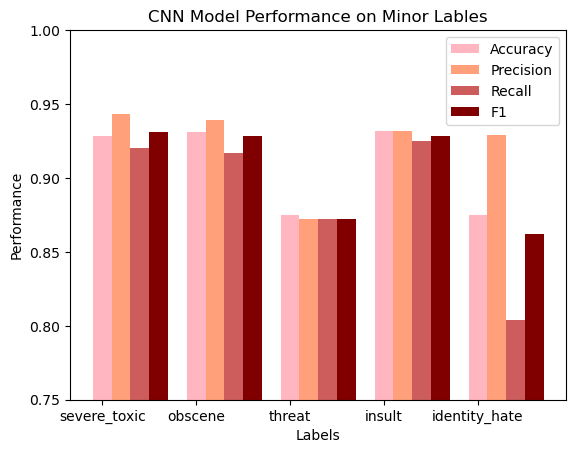

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

index = ["severe_toxic", "obscene", "threat", "insult", "identity_hate"]
columns = ["Accuracy", "Precision", "Recall", "F1"]
colors = ['#FFB6C1', '#FFA07A', '#CD5C5C', '#800000']

# Set the width of each bar
bar_width = 0.2

# Create a figure and axes
fig, ax = plt.subplots()

# Iterate over the columns and plot the grouped bars
for i, col in enumerate(columns):
    bar_positions = np.arange(len(index)) + (i * bar_width)
    values = minor_metrics[col].values
    ax.bar(bar_positions, values, width=bar_width, color=colors[i], label=col)

# Set the x-axis labels and tick positions
ax.set_xticks(np.arange(len(index)))
ax.set_xticklabels(index)

# Add a legend and labels
ax.legend()
ax.set_xlabel('Labels')
ax.set_ylabel('Performance')
ax.set_ylim(0.75, 1)

plt.title('CNN Model Performance on Minor Lables')
# Show the plot
plt.show()


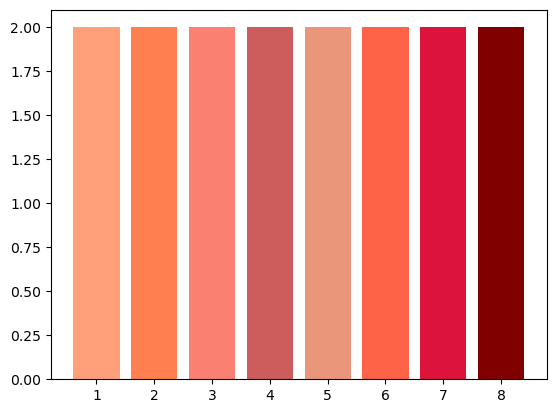

In [115]:
import matplotlib.pyplot as plt
x = [1,2,3,4,5,6,7,8]
y = [2]* 8

# Specify colors using hexadecimal color codes
colors = ['#FFA07A', '#FF7F50', '#FA8072', '#CD5C5C', '#E9967A', '#FF6347', '#DC143C', '#800000']

# Plotting example
plt.bar(x, y, color=colors)  # Replace x and y with your actual data
plt.show()
